##  <span style='color:green '>Evaluate Models Rookies Non-QB Skills</span>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')
import nfl_data_py as nfl
max_col = pd.get_option("display.max_columns")

###  <span style='color:green '> Set up variables to be used in Fit Determination Function</span>

In [2]:
index = []
scores = {'Train Score': [], "Test Score": [], 'Test Train Difference': [], 'Scaler': []}
scalers = ["none", StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()]
models = [LinearRegression(),
          LogisticRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(),
          RandomForestClassifier(),
          ExtraTreesRegressor(),
          ExtraTreesClassifier(),
          AdaBoostRegressor(),
          AdaBoostClassifier()]

###  <span style='color:green '>Define Function to Test Models and Scalers</span>

In [3]:
def test_model(data):
    for scaler in scalers:
        global index
        global scores
        if scaler != "none":
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test
        data = X_train_scaled, X_test_scaled, y_train, y_test
        for model in models:
            reg = model.fit(X_train_scaled, y_train)
            y_pred = reg.predict(X_test_scaled)            
            scores["Train Score"].append(reg.score(X_train_scaled, y_train))
            scores["Test Score"].append(reg.score(X_test_scaled, y_test))
            scores["Test Train Difference"].append((reg.score(X_train_scaled, y_train)-(reg.score(X_test_scaled, y_test))))
            scores["Scaler"].append(scaler)
            index += [type(reg).__name__]

###  <span style='color:green '>Get data and evaluate readiness for model</span>

 <span style='color:green '>* Find features and target   
     * Test for imbalance </span>

In [4]:
nfl.see_pbp_cols() # Displays available columns
pbp2021 = nfl.import_pbp_data(years=[2021], downcast=True, cache=False, alt_path=None)

# load additional team data 
pbpclean = pbp2021
teams = nfl.import_team_desc()
players = nfl.import_rosters([2021])
player_seasons = nfl.import_seasonal_data([2021])
player_seasons.head(5)

adp = pd.read_csv('Resources/Rookies_RB_WR_TE.csv') 

adp['2019 FantasyPoints'] = 0
adp['2020 FantasyPoints'] = 0
adp['Average Total Production'] = 0
adp['Production21'] = 0
adp = adp.rename(columns={'2021 Fantasy Points':'2021 FantasyPoints'})

2021 done.
Downcasting floats.


In [5]:
# Preserve label information for Output file 
adp_scope = adp[['Player',
                 '2021 FantasyPoints',
                 '2021 Tm',
                 'Pos',
                 'AVG'
                ]].copy()

adp_scope['2019 FantasyPoints'] = 0
adp_scope['2020 FantasyPoints'] = 0
adp_scope['Average Total Production'] = 0
adp_scope['Production21'] = 0
adp_scope.head(5)

,Player,2021 FantasyPoints,2021 Tm,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21
0,Breece Hall,176.8,NYJ,RB,43.0,0,0,0,0
1,Drake London,113.5,ATL,WR,110.8,0,0,0,0
2,Ken Walker III,105.6,SEA,RB,87.8,0,0,0,0
3,Treylon Burks,116.2,TEN,WR,123.0,0,0,0,0
4,Jameson Williams,70.3,DET,WR,167.0,0,0,0,0


In [6]:
# Replace infinite updated data with 'drop'
# drop these rows from what will become our result set 
adp_scope.replace([np.inf, -np.inf], 'drop', inplace=True)
res = adp_scope[~adp_scope.eq('drop').any(1)]
adp_scope  = res
adp_scope.head(5)

,Player,2021 FantasyPoints,2021 Tm,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21
0,Breece Hall,176.8,NYJ,RB,43.0,0,0,0,0
1,Drake London,113.5,ATL,WR,110.8,0,0,0,0
2,Ken Walker III,105.6,SEA,RB,87.8,0,0,0,0
3,Treylon Burks,116.2,TEN,WR,123.0,0,0,0,0
4,Jameson Williams,70.3,DET,WR,167.0,0,0,0,0


In [7]:
# Get the mean of the Average of the Average Draft Position 
meanJoeGreen = adp["AVG"].mean()
adp["AVG"] = adp["AVG"].fillna(meanJoeGreen)

In [8]:
# Invert ADP
adp['AvgInvert'] = (adp['AVG'].max() + 1) - adp['AVG']
# Give Production Scores and Most recent Fantasy Point equal Weight
adp['ProdWeighted'] = adp['2021 FantasyPoints']
# Factor in "human factor" of current ADP
adp['ProdWeightedSRA'] = (adp['ProdWeighted'] + adp['AvgInvert'])/2
# Correct any Nulls created by source data errors 
adp["ProdWeightedSRA"] = adp["ProdWeightedSRA"].fillna(114)
adp.head(5)

,Unnamed: 0,Player,2021 Tm,2021 Rec,2021 RushingYds,2021 ReceivingTD,2021 FantasyPoints,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21,AvgInvert,ProdWeighted,ProdWeightedSRA
0,0,Breece Hall,NYJ,39.3,991.7,6.7,176.8,RB,43.0,0,0,0,0,354.0,176.8,265.40
1,1,Drake London,ATL,65.5,863.7,4.7,113.5,WR,110.8,0,0,0,0,286.2,113.5,199.85
2,2,Ken Walker III,SEA,17.6,643.8,4.6,105.6,RB,87.8,0,0,0,0,309.2,105.6,207.40
3,3,Treylon Burks,TEN,58.7,834.8,5.0,116.2,WR,123.0,0,0,0,0,274.0,116.2,195.10
4,4,Jameson Williams,DET,38.3,526.0,3.1,70.3,WR,167.0,0,0,0,0,230.0,70.3,150.15


In [9]:
adp_production = adp[['Player',
                     '2019 FantasyPoints',
                     '2020 FantasyPoints',
                     '2021 FantasyPoints',
                     'ProdWeighted',
                     '2021 Tm',
                     'Pos',
                     'AVG'
                    ]].copy()

In [10]:
# Verify that 2021 production has corrected values 
adp["Production21"].value_counts()

0    62
Name: Production21, dtype: int64

In [11]:
# Check for invalid data
count_nan = adp.isna().sum().sum()
count_nan

0

In [12]:
# Identify invalid data 
# These columns are drop from the ML Dataset 
# They are added back to the results set 
# they will still need to be corrected in the 
# previous step. 
missing_average = adp['AVG'].isna().sum()
missing_pos = adp['Pos'].isna().sum()
missing_team = adp['2021 Tm'].isna().sum()
print(f'Column AVG has {missing_average} null values')
print(f'Column POS has {missing_pos} null values')
print(f'Column Team has {missing_team} null values')

Column AVG has 0 null values
Column POS has 0 null values
Column Team has 0 null values


In [13]:
# Remove unnamed column, Player, Pos and 2021 Team
col = [0,1,2]
adp.drop(adp.columns[col],axis=1,inplace=True)

# For rookies only drop the 'Pos' column by name 
# Arrives in a different order
adp.drop('Pos', axis=1, inplace=True)
adp.head(5)

,2021 Rec,2021 RushingYds,2021 ReceivingTD,2021 FantasyPoints,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21,AvgInvert,ProdWeighted,ProdWeightedSRA
0,39.3,991.7,6.7,176.8,43.0,0,0,0,0,354.0,176.8,265.40
1,65.5,863.7,4.7,113.5,110.8,0,0,0,0,286.2,113.5,199.85
2,17.6,643.8,4.6,105.6,87.8,0,0,0,0,309.2,105.6,207.40
3,58.7,834.8,5.0,116.2,123.0,0,0,0,0,274.0,116.2,195.10
4,38.3,526.0,3.1,70.3,167.0,0,0,0,0,230.0,70.3,150.15


In [14]:
# Check for remaining nulls 
count_nan = adp.isna().sum().sum()
count_nan

0

In [15]:
# Look for non numerics 
adp.applymap(np.isreal)
invalidNumbers = adp[~adp.applymap(np.isreal).all(1)]
if len(invalidNumbers) > 0:
    print((f'There are {len(invalidNumbers)} rows with invaid numeric data'))

In [16]:
# This may not be required for rookie dataset
# Correct "inf" and "-inf" values 
# Replace infinite updated data with nan
adp.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN that were just created by the infinity value replacements
adp.dropna(inplace=True)

In [17]:
# Set Target Variable 
Target = adp["ProdWeightedSRA"].values

In [18]:
print(len(Target))

62


###  <span style='color:green '>Apply Scaling for Initial Model Test </span>

In [19]:
# Standarize data with StandardScaler
# adps = StandardScaler().fit_transform(adp)
adps = MinMaxScaler().fit_transform(adp)
print(adps[0:1])

[[0.58805031 1.         1.         1.         0.         0.
  0.         0.         0.         1.         1.         1.        ]]


###  <span style='color:green '> PCA</span>
<span style='color:green '> Applying PCA to reduce dimensions while preserving 99% of the explained variance </span>

In [20]:
# Applying PCA to reduce dimensions while preserving 90% of the explained variance 
# Initialize PCA model by setting n-components to desired level
pca = PCA(n_components= .99)

# Fit our new Principal Component Analysis reduced Features to our Model
pfa = pca.fit_transform(adps)

# Transform PCA data to a DataFrame
pf = pd.DataFrame(data=pfa)
pf.head(2)

,0,1,2
0,1.721366,-0.176638,0.343624
1,1.246097,0.190772,-0.224733


###  <span style='color:green '>Create X and Y | Reshape the data</span>

In [21]:
# Create X (features) and y (target) sets
X = pf
y = Target

print("Shape: ", X.shape, y.shape)

Shape:  (62, 3) (62,)


###  <span style='color:green '>Split data into Training and Testing sets</span>

In [22]:
# Split the data into training and testing sets
data = X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

###  <span style='color:green '>Get to know our data</span>

Training Data Score: 1.0
Testing Data Score: 0.9158852077722878


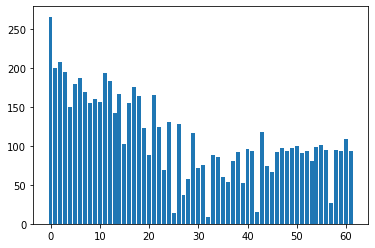

Wall time: 362 ms


In [23]:
%%time
# setting Random forest as sample to view data 
classifier = ExtraTreesRegressor()
# classifier = LinearRegression()
clf = classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

# Does not apply to linear Regression 
# features = clf.feature_importances_
# print(features)

# Plot for Linear Regression Model 
# Plots entire dataset not useful on large data 
plt.bar(x = range(len(X)), height=y)
plt.show()

In [24]:
y_predicted = clf.predict(X_test)
scores1 = clf.score(X_test, y_test)

print(y_predicted)
print(scores1)

[100.3969      94.56172222 197.721       42.2505     183.0375
  93.5119     159.3505     182.06        13.906       93.51322222
  72.46165556 159.9685      97.18343333 151.1785      88.01593333
  88.61332222]
0.9158852077722878


In [25]:
y_predicted = clf.predict(X)
print(y_predicted)

[197.721      199.85       207.4        195.1        150.15
 183.0375     186.6        168.3        154.35       159.9685
 156.05       193.4        182.06       151.1785     165.75
 101.9        159.3505     174.7        163.5        122.5
  87.65       164.5        124.45        69.3        130.05
  13.906      127.8         36.3         56.95       117.
  72.46165556  75.6          8.45        88.01593333  88.61332222
  59.35        53.          80.95        91.58222222  51.95
  95.58222222  93.43222222  15.35       117.15        73.75
  66.3         92.48222222  97.18343333  93.5119      97.08222222
 100.3969      90.63222222  93.58222222  80.45        98.28222222
 101.58222222  94.56172222  42.2505      95.08222222  93.51322222
 108.98222222  93.73222222]


In [26]:
adp_scope['Prediction'] = y_predicted
adp_scope.rename(columns={"2021 Tm": "Team"})

,Player,2021 FantasyPoints,Team,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21,Prediction
0,Breece Hall,176.8,NYJ,RB,43.0,0,0,0,0,197.721000
1,Drake London,113.5,ATL,WR,110.8,0,0,0,0,199.850000
2,Ken Walker III,105.6,SEA,RB,87.8,0,0,0,0,207.400000
3,Treylon Burks,116.2,TEN,WR,123.0,0,0,0,0,195.100000
4,Jameson Williams,70.3,DET,WR,167.0,0,0,0,0,150.150000
...,...,...,...,...,...,...,...,...,...,...
57,Jalen Nailor,5.8,MIN,WR,350.0,0,0,0,0,42.250500
58,Samori Toure,12.4,GB,WR,NaN,0,0,0,0,95.082222
59,Michael Woods II,8.1,FA,WR,NaN,0,0,0,0,93.513222
60,Tyler Goodson,40.2,GB,RB,NaN,0,0,0,0,108.982222


In [27]:
adp_scope.sort_values('Prediction', ascending=False).head(50)

,Player,2021 FantasyPoints,2021 Tm,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21,Prediction
2,Ken Walker III,105.6,SEA,RB,87.8,0,0,0,0,207.400000
1,Drake London,113.5,ATL,WR,110.8,0,0,0,0,199.850000
0,Breece Hall,176.8,NYJ,RB,43.0,0,0,0,0,197.721000
3,Treylon Burks,116.2,TEN,WR,123.0,0,0,0,0,195.100000
11,James Cook,100.3,BUF,RB,110.5,0,0,0,0,193.400000
6,Chris Olave,98.5,NO,WR,122.3,0,0,0,0,186.600000
5,Garrett Wilson,97.6,NYJ,WR,137.3,0,0,0,0,183.037500
12,Dameon Pierce,100.3,HOU,RB,131.8,0,0,0,0,182.060000
17,Isaiah Spiller,82.7,LAC,RB,130.3,0,0,0,0,174.700000
7,Skyy Moore,86.9,KC,WR,147.3,0,0,0,0,168.300000


In [28]:
# save
joblib.dump(classifier, "Resources/draft_Rookie.joblib")

# Temporary write file while we are working on data ***
adp_scope.dropna(subset=['AVG'])

adp_scope.to_csv('Resources/Draft_Rookie.csv', index=False)

### <span style='color:green '>The section below is to evaluate new potential Models </span>

In [29]:
# Create X (features) and y (target) sets
X = pf

#convert y values to categorical values(for model selection matrix)
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)
y = y_transformed

# Split the data into training and testing sets
data = X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)
print(len(y))
print(len(X))

62
62


In [30]:
%%time
# call function test_model to test all models being considered
scores = {'Train Score': [], "Test Score": [], 'Test Train Difference': [], 'Scaler': []}
test_model(data)

Wall time: 3.28 s


In [31]:
# Print by Training Score
df_scores = pd.DataFrame(scores, index=index)
df_scores.sort_values('Train Score', ascending=False).head(25)

,Train Score,Test Score,Test Train Difference,Scaler
RandomForestClassifier,1.000000,0.000000,1.000000,MinMaxScaler()
ExtraTreesClassifier,1.000000,0.000000,1.000000,RobustScaler()
ExtraTreesClassifier,1.000000,0.000000,1.000000,MaxAbsScaler()
ExtraTreesClassifier,1.000000,0.000000,1.000000,MinMaxScaler()
RandomForestClassifier,1.000000,0.000000,1.000000,RobustScaler()
RandomForestClassifier,1.000000,0.000000,1.000000,MaxAbsScaler()
RandomForestClassifier,1.000000,0.000000,1.000000,StandardScaler()
ExtraTreesClassifier,1.000000,0.000000,1.000000,StandardScaler()
ExtraTreesClassifier,1.000000,0.000000,1.000000,none
RandomForestClassifier,1.000000,0.000000,1.000000,none


In [32]:
# Print by Testing Score
df_scores.sort_values('Test Score', ascending=False).head(25)

,Train Score,Test Score,Test Train Difference,Scaler
KNeighborsRegressor,0.972518,0.984354,-0.011836,none
ExtraTreesRegressor,0.999997,0.983946,0.016051,StandardScaler()
ExtraTreesRegressor,0.999999,0.980266,0.019732,none
ExtraTreesRegressor,0.999998,0.979747,0.020251,MaxAbsScaler()
ExtraTreesRegressor,0.999999,0.976357,0.023641,RobustScaler()
ExtraTreesRegressor,0.999999,0.967561,0.032438,MinMaxScaler()
KNeighborsRegressor,0.960146,0.964539,-0.004393,MaxAbsScaler()
KNeighborsRegressor,0.960047,0.964539,-0.004492,MinMaxScaler()
KNeighborsRegressor,0.948299,0.951894,-0.003595,StandardScaler()
KNeighborsRegressor,0.946859,0.947340,-0.000481,RobustScaler()


In [33]:
# Print by Testing Score
df_scores['Test Train Magnitude'] = abs(df_scores['Test Train Difference'])
df_scores.sort_values('Test Train Magnitude').head(25)

,Train Score,Test Score,Test Train Difference,Scaler,Test Train Magnitude
KNeighborsRegressor,0.946859,0.947340,-0.000481,RobustScaler(),0.000481
KNeighborsRegressor,0.948299,0.951894,-0.003595,StandardScaler(),0.003595
KNeighborsRegressor,0.960146,0.964539,-0.004393,MaxAbsScaler(),0.004393
KNeighborsRegressor,0.960047,0.964539,-0.004492,MinMaxScaler(),0.004492
KNeighborsRegressor,0.972518,0.984354,-0.011836,none,0.011836
ExtraTreesRegressor,0.999997,0.983946,0.016051,StandardScaler(),0.016051
ExtraTreesRegressor,0.999999,0.980266,0.019732,none,0.019732
ExtraTreesRegressor,0.999998,0.979747,0.020251,MaxAbsScaler(),0.020251
ExtraTreesRegressor,0.999999,0.976357,0.023641,RobustScaler(),0.023641
ExtraTreesRegressor,0.999999,0.967561,0.032438,MinMaxScaler(),0.032438


For the rookie model we had to look a little deeper into our training scores, due to the limited dataset models naturally over train and testing rates fall dramatically.

Viewing our results it does appear that KNeighbors and ExtraTrees are a better choice. 